# CIFAR-10 CNN

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 60.000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 classes com 6.000 imagens por classe. 

O exemplo abaixo é uma adaptação do exemplo fornecido na documentação do Keras: 
https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py Nele, nós utilizamos apenas 3 das 10 classes. A saída das diferentes camadas da CNN são mostradas.

## Importando as bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys, os
np.random.seed(1337)  # for reproducibility
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import RMSprop
sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())
!nvidia-smi

Backend:        tensorflow
Data format:    channels_first
Available GPUS: []
/bin/sh: nvidia-smi: command not found


## Código de apoio ao treinamento

In [4]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Carregando e mostrando os dados

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)

X_train.shape: (50000, 3, 32, 32)
X_test.shape: (10000, 3, 32, 32)


## Selecionando apenas objetos das classes: 0, 1, 2

In [6]:
nb_classes = 3 #Número de classes
indexes_train = (y_train == 0) | (y_train == 1) | (y_train == 2)
X_train = X_train[indexes_train]
y_train = y_train[indexes_train]

indexes_test = (y_test == 0) | (y_test == 1) | (y_test == 2) 
X_test = X_test[indexes_test]
y_test = y_test[indexes_test]

print('X_train shape:', X_train.shape)
print('X_test shape:)', X_test.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

X_train shape: (15000, 3, 32, 32)
X_test shape:) (3000, 3, 32, 32)
15000 amostras de treinamento
3000 amostras de teste


## Mostrando algumas imagens do conjunto de teste

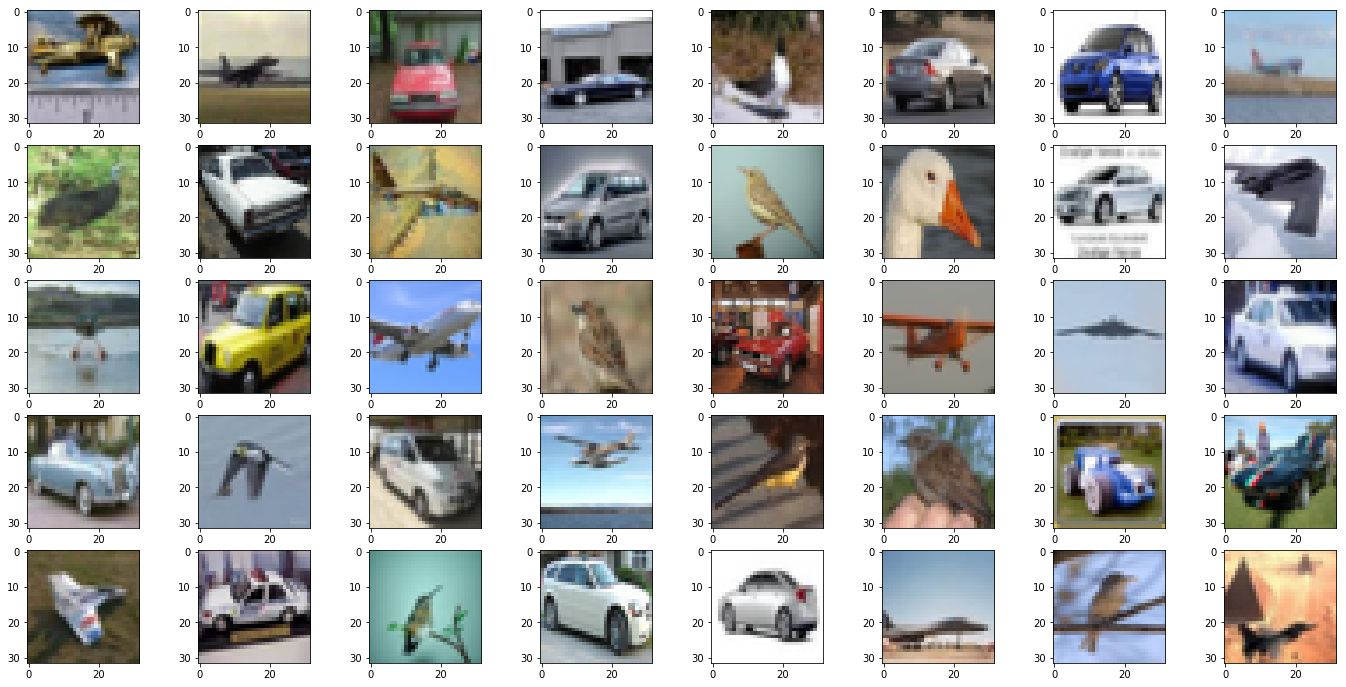

In [7]:
plt.figure(figsize=(24, 12))

for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(40,))):
    plt.subplot(5, 8, k + 1)
    image = X_test[i]
    plt.imshow(image.reshape(3,32,32).transpose((1,2,0)))
    

## Normalização dos dados

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

## Teste inicial com pouquíssimas amostras

In [9]:
testing = True
if testing:
    n_samples = np.int(2*1280*(1+0.34))
    X_train = X_train[:n_samples]
    y_train = y_train[:n_samples]
    n_samples_test = 500
    X_test = X_test[:n_samples_test]
    y_test = y_test[:n_samples_test]

## Transforma o vetor de labels para o formato de one-hot encoding.

In [10]:
y_train_oh = np_utils.to_categorical(y_train, nb_classes)
y_test_oh = np_utils.to_categorical(y_test, nb_classes)

# Construíndo a CNN com o Keras

In [11]:
def model_build():
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    input_shape = (3, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    return model

model = model_build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 28, 28)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

## Treinamento da rede

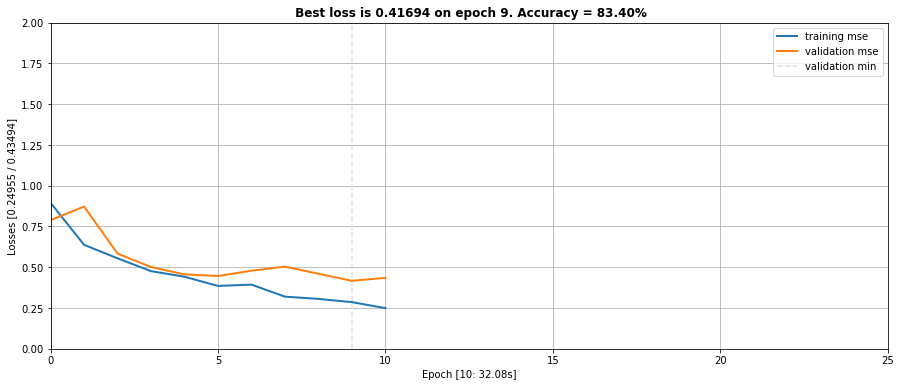

In [12]:
model_name = '../../models/cifar_1'
fit_params = {
    'model_name': model_name,
    'loss':       'categorical_crossentropy',
    'opt':        RMSprop(),
    'batch_size': 100, 
    'nepochs':    25,
    'patience':   5,
    'ploss':      2.,
    'reset':      False,
}

train_network(model, X_train, y_train_oh, X_test, y_test_oh, **fit_params);

## Avaliação do treinamento no conjunto de testes

In [18]:
test_network(model_name, X_test, y_test_oh)

Model from epoch 9
[INFO] evaluating in the test data set ...
500/500 [==============================] - 2s     

[INFO] accuracy on the test data set: 83.40% [0.41694]


In [14]:
print('Rótulos conj. teste:',y_test[:10])
y_hat = model.predict_classes(X_test[:10],verbose=0)
print('Rótulos previstos:  ',y_hat[:10])
y_prob = model.predict_proba(X_test[:10],verbose=0)
print('probabilidades:\n',y_prob)

Rótulos conj. teste: [0 1 1 0 0 2 0 2 1 0]
Rótulos previstos:   [1 1 2 1 1 2 1 2 2 2]
probabilidades:
 [[ 0.30532172  0.36679003  0.32788825]
 [ 0.32570523  0.34313706  0.33115768]
 [ 0.30356592  0.34279662  0.35363746]
 [ 0.32037112  0.3477903   0.33183861]
 [ 0.31580871  0.36976823  0.31442308]
 [ 0.32070711  0.32959619  0.34969676]
 [ 0.31356528  0.34372896  0.34270573]
 [ 0.31020984  0.34327358  0.34651652]
 [ 0.28888151  0.34980589  0.36131263]
 [ 0.31094006  0.3325907   0.35646927]]


In [23]:
y_hat = model.predict_classes(X_test)
acc = (y_hat == y_test).sum()/y_hat.size
print('Acurácia:', acc)

500/500 [==============================] - 2s     
0.274


## Função que desenha o mosaico

In [ ]:
def mosaic(f,N):
    d,h,w = f.shape
    nLines = np.int(np.ceil(float(d)/N))
    nCells = nLines*N
        
    fullf = np.resize(f, (nCells,h,w))
    fullf[d:nCells,:,:] = 0        
        
    Y,X = np.indices((nLines*h,N*w))
    Pts = np.array([
                   (np.floor(Y/h)*N + np.floor(X/w)).ravel(),
                   np.mod(Y,h).ravel(),
                   np.mod(X,w).ravel() ]).astype(int).reshape((3,int(nLines*h),int(N*w)))
    g = fullf[Pts[0],Pts[1],Pts[2]]
    return g

## Visualização de uma amostra

In [ ]:
sn = 70  # amostra de número 70
plt.figure()
plt.imshow(X_test[sn].transpose((1,2,0)))
#plt.axis('off')
plt.title("Original");

## Visualização das camadas internas

In [ ]:
ncols = 8
H,W = 10,30

#Mostrando a saida das camadas convolucionais
for layer in model.layers[0:5]:
    i_model = Model(inputs=model.input,outputs=layer.output)
    i_output = i_model.predict(X_test[sn].reshape(1,3,32,32))
    sub_dim = i_output.shape[1]
    name = str(layer).split('.')[3].split(" ")[0]
    if name =="MaxPooling2D":
        H = H//2
        W = W//2
    fig =plt.figure(figsize=(H,W))
    aux = i_output[0,:,:,:]
    mos = mosaic(aux,ncols)
    plt.imshow(mos,cmap = 'gray')
    plt.axis('off')
    plt.title(name)

## Atividades

1. Quantos parâmetros são treinados nesta rede? Calcule o número de parâmetros de cada camada, não se esquecendo do *bias*. Confira o valor calculado com o `summary` do Keras.
2. Se as duas camadas convolucionais fossem densas, qual seria o número de parâmetros a serem treinados?
3. Altere o notebook para que ele seja processado na formato de imagens "channels_last".

## Aprendizados com este experimento
